# Dynamic Cost-To-Go (a single GMM cell)

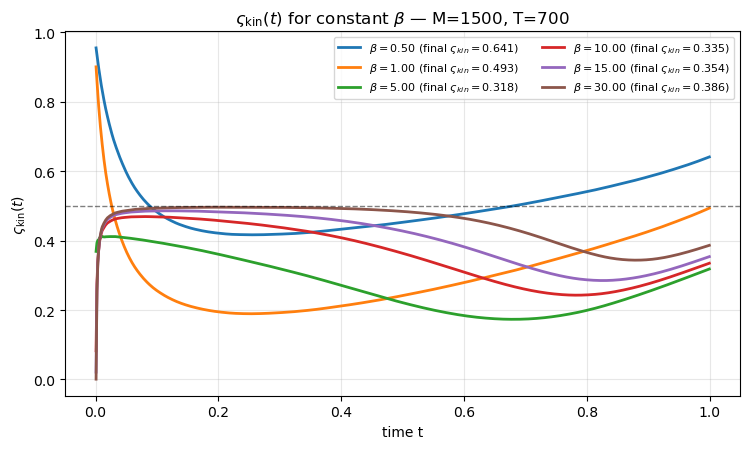

[saved] figs/varsigma_kin_vs_time_constbeta_M1500_T700_x0zero.png


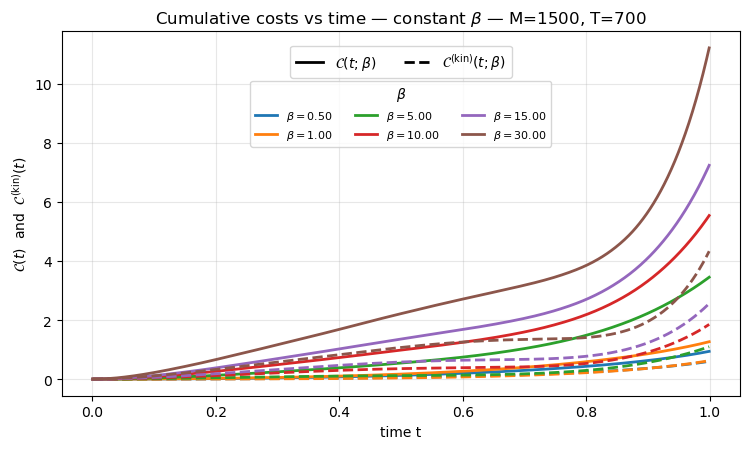

[saved] figs/C_vs_time_constbeta_M1500_T700_x0zero.png


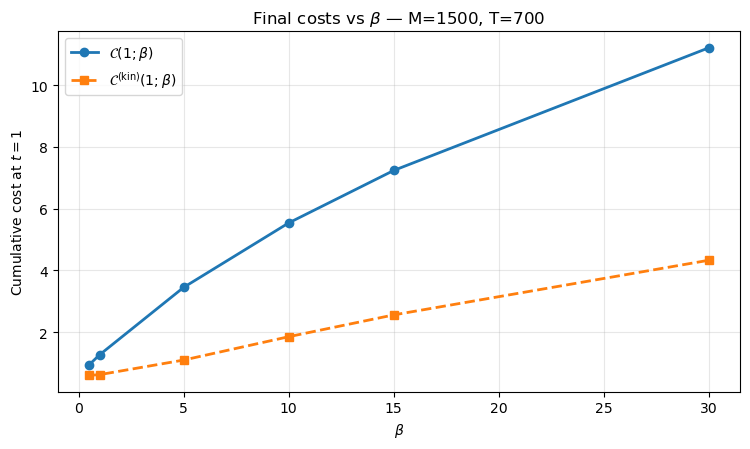

[saved] figs/Cfinal_vs_beta_constbeta_M1500_T700_x0zero.png
     β          C(1)      C_kin(1)      C_pot(1)   varsig_kin(1)
  0.50      0.940911      0.602997      0.337914        0.640865
  1.00      1.266921      0.625070      0.641851        0.493378
  5.00      3.450947      1.097741      2.353206        0.318099
 10.00      5.538951      1.854113      3.684838        0.334741
 15.00      7.239004      2.560676      4.678328        0.353733
 30.00     11.213762      4.331498      6.882264        0.386266


In [3]:
import sys
from ada_api_clean import *


# =======================================================
# Dynamic Cost-to-Go — varsigmas vs time  [x(0)=0]
#   • Uses interior midpoints t_n=(n+0.5)/T only (never t=0 or t=1)
#   • Potential integrand: (1/2)·β(t)·E[||x_t||²]
#   • SDE: dX = u*(X,t) dt + dW (unit diffusion)
#   • Returns:
#       t_mid  : (T,)        midpoints in (0,1)
#       z_kin  : (T,)        C_kin / (C_kin + C_pot) over time
#       z_pot  : (T,)        1 - z_kin
#       Ckin_T : (scalar)    final ∫ (1/2)||u||² dt
#       Cpot_T : (scalar)    final ∫ (1/2)β(t)E||x||² dt
#   • Extra (when return_series=True):
#       Ckin_series, Cpot_series : (T,) cumulative costs over time
#   • This version ENFORCES x(0)=0 by default (set x0="zero")
# =======================================================

import numpy as np, math
import matplotlib.pyplot as plt
import os

os.makedirs("figs", exist_ok=True)

# ---- read β(t) from schedule (PWC or constant) ----
def beta_of_t_from_sched(sched, t: float) -> float:
    if hasattr(sched, "betas") and hasattr(sched, "splits"):  # PWC
        splits = np.asarray(sched.splits, float)
        i = np.searchsorted(splits, float(t), side="right") - 1
        i = max(0, min(i, len(sched.betas) - 1))
        return float(sched.betas[i])
    if hasattr(sched, "beta"):  # constant-β
        return float(sched.beta)
    raise RuntimeError("Schedule must expose either .betas/.splits (PWC) or .beta (constant).")

# ---- endpoint-safe budgets ----
def varsigmas_vs_time(sched, gmm, M: int = 2000, T: int = 800, seed: int = 123, x0: str = "zero",
                      return_series: bool = False):
    """
    Simulate with midpoint EM using unit diffusion, accumulate kinetic and potential budgets.
    x0:
      "zero"     -> X(0)=0 for all particles (default; recommended for consistency)
      "gaussian" -> X(0) ~ N(0, I)
    """
    rng = np.random.default_rng(seed)
    dt    = 1.0 / T
    t_mid = (np.arange(T) + 0.5) / T  # strictly inside (0,1)

    d = gmm.d
    if x0 == "zero":
        X = np.zeros((M, d), float)
    else:
        X = rng.normal(size=(M, d))

    Ckin_T = 0.0
    Cpot_T = 0.0
    z_kin  = np.empty(T, float)
    z_pot  = np.empty(T, float)
    if return_series:
        Ckin_series = np.empty(T, float)
        Cpot_series = np.empty(T, float)

    for n, t in enumerate(t_mid):
        # optimal control u* = b^- ŷ − a^- X
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X

        # advance state
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u * dt + dW

        # accumulate budgets
        Ckin_T += 0.5 * float(np.mean(np.sum(u*u, axis=1))) * dt
        beta_t  = beta_of_t_from_sched(sched, float(t))
        Cpot_T += 0.5 * beta_t * float(np.mean(np.sum(X*X, axis=1))) * dt

        if return_series:
            Ckin_series[n] = Ckin_T
            Cpot_series[n] = Cpot_T

        denom = max(Ckin_T + Cpot_T, 1e-30)
        z_kin[n] = Ckin_T / denom
        z_pot[n] = 1.0 - z_kin[n]

    if return_series:
        return t_mid, z_kin, z_pot, Ckin_T, Cpot_T, Ckin_series, Cpot_series
    else:
        return t_mid, z_kin, z_pot, Ckin_T, Cpot_T

# several constant-β curves on one figure ----

gmm=pertA

beta_list = [0.5, 1.0, 5.0, 10.0, 15.0, 30.0]
M   = 1500
T   = 700
seed = 42

# ===================== Figure 1: z_kin(t) (x(0)=0) =====================
plt.figure(figsize=(7.6, 4.6))
for b in beta_list:
    sched = BetaSchedulePWC.constant(float(b))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)  # interior sanity
    t, zkin, zpot, Ck, Cp = varsigmas_vs_time(sched, gmm, M=M, T=T, seed=seed, x0="zero")
    plt.plot(t, zkin, lw=2.0, label=fr"$\beta={b:.2f}$ (final $\varsigma_{{kin}}={zkin[-1]:.3f}$)")

plt.axhline(0.5, ls="--", lw=1.0, color="k", alpha=0.5)
plt.xlabel("time t")
plt.ylabel(r"$\varsigma_{\mathrm{kin}}(t)$")
plt.title(fr"$\varsigma_{{\mathrm{{kin}}}}(t)$ for constant $\beta$ — M={M}, T={T}")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
out_path1 = f"figs/varsigma_kin_vs_time_constbeta_M{M}_T{T}_x0zero.png"
plt.savefig(out_path1, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {out_path1}")

# ===================== Figure 2: C(t;β) & C_kin(t;β) (x(0)=0) =====================
from matplotlib.lines import Line2D

plt.figure(figsize=(7.6, 4.6))

cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
beta_handles, beta_labels = [], []

for i, b in enumerate(beta_list):
    color_i = cycle_colors[i % len(cycle_colors)]
    sched = BetaSchedulePWC.constant(float(b))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)

    t, _, _, Ckin_T, Cpot_T, Ckin_series, Cpot_series = varsigmas_vs_time(
        sched, gmm, M=M, T=T, seed=seed, x0="zero", return_series=True
    )
    Ctot_series = Ckin_series + Cpot_series

    plt.plot(t, Ctot_series, lw=2.0, color=color_i)
    plt.plot(t, Ckin_series, lw=2.0, ls="--", color=color_i)

    beta_handles.append(Line2D([0],[0], color=color_i, lw=2))
    beta_labels.append(fr"$\beta={b:.2f}$")

plt.xlabel("time t")
plt.ylabel(r"$\mathcal{C}(t)$  and  $\mathcal{C}^{(\mathrm{kin})}(t)$")
plt.title(fr"Cumulative costs vs time — constant $\beta$ — M={M}, T={T}")
plt.grid(True, alpha=0.3)

# legends at top-center (stacked)
ax = plt.gca()
style_handles = [
    Line2D([0],[0], color="k", lw=2.0, ls="-"),
    Line2D([0],[0], color="k", lw=2.0, ls="--"),
]
style_labels = [r"$\mathcal{C}(t;\beta)$", r"$\mathcal{C}^{(\mathrm{kin})}(t;\beta)$"]

leg_styles = ax.legend(
    style_handles, style_labels,
    loc="upper center", bbox_to_anchor=(0.5, 0.98), ncol=2, frameon=True
)
ax.add_artist(leg_styles)

ax.legend(
    beta_handles, beta_labels,
    loc="upper center", bbox_to_anchor=(0.5, 0.88), ncol=3, fontsize=8, title=r"$\beta$",
    frameon=True
)

plt.tight_layout()
out_path2 = f"figs/C_vs_time_constbeta_M{M}_T{T}_x0zero.png"
plt.savefig(out_path2, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {out_path2}")

# ===================== Figure 3: C(1;β) & C_kin(1;β) vs β (x(0)=0) =====================
Ctot_final = []
Ckin_final = []
Cpot_final = []
zkin_final = []

for b in beta_list:
    sched = BetaSchedulePWC.constant(float(b))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)
    _, _, _, Ckin_T, Cpot_T = varsigmas_vs_time(sched, gmm, M=M, T=T, seed=seed, x0="zero")
    Ctot_final.append(Ckin_T + Cpot_T)
    Ckin_final.append(Ckin_T)
    Cpot_final.append(Cpot_T)
    denom = max(Ckin_T + Cpot_T, 1e-30)
    zkin_final.append(Ckin_T / denom)

Ctot_final = np.array(Ctot_final, float)
Ckin_final = np.array(Ckin_final, float)
Cpot_final = np.array(Cpot_final, float)
zkin_final = np.array(zkin_final, float)

plt.figure(figsize=(7.6, 4.6))
plt.plot(beta_list, Ctot_final, marker="o", lw=2.0, label=r"$\mathcal{C}(1;\beta)$")
plt.plot(beta_list, Ckin_final, marker="s", lw=2.0, ls="--", label=r"$\mathcal{C}^{(\mathrm{kin})}(1;\beta)$")
plt.xlabel(r"$\beta$")
plt.ylabel(r"Cumulative cost at $t=1$")
plt.title(fr"Final costs vs $\beta$ — M={M}, T={T}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
out_path3 = f"figs/Cfinal_vs_beta_constbeta_M{M}_T{T}_x0zero.png"
plt.savefig(out_path3, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {out_path3}")

# (optional) print terminal table
print(f"{'β':>6}  {'C(1)':>12}  {'C_kin(1)':>12}  {'C_pot(1)':>12}  {'varsig_kin(1)':>14}")
for b, Ct, Ck, Cp, zk in zip(beta_list, Ctot_final, Ckin_final, Cpot_final, zkin_final):
    print(f"{b:6.2f}  {Ct:12.6f}  {Ck:12.6f}  {Cp:12.6f}  {zk:14.6f}")


# Three panels -- for three GMM models -- big range of $\beta$

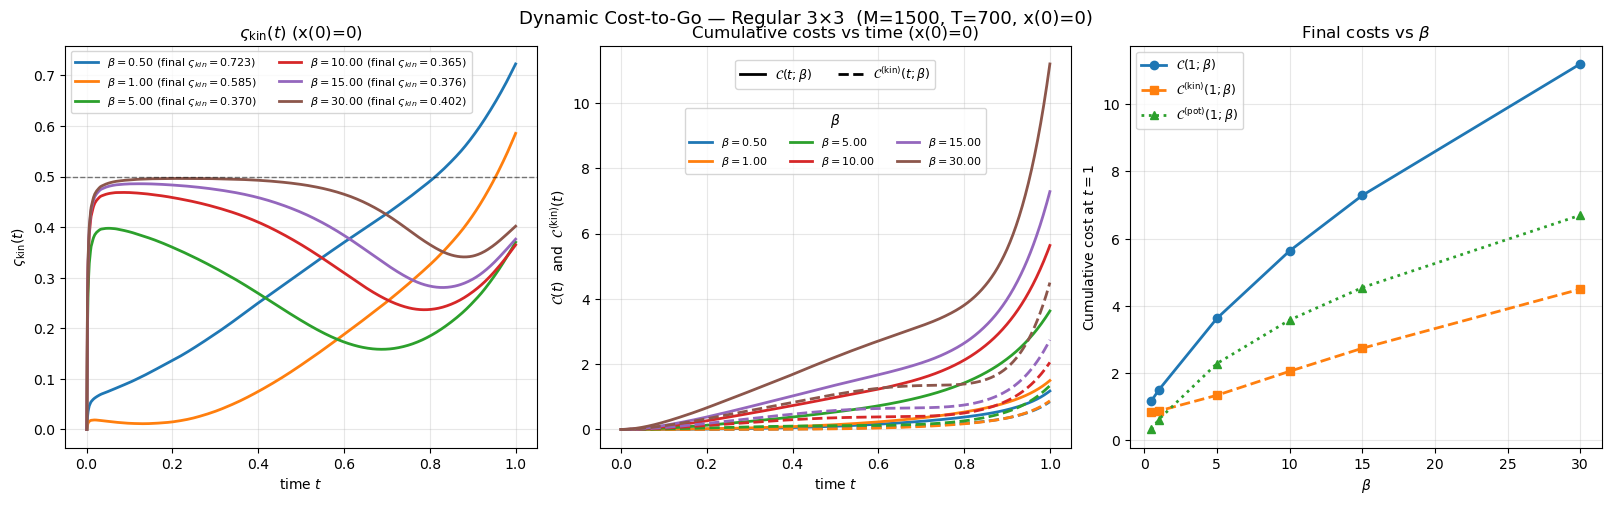

[saved] figs/CostToGo_panels_M1500_T700_regular_3x3.png


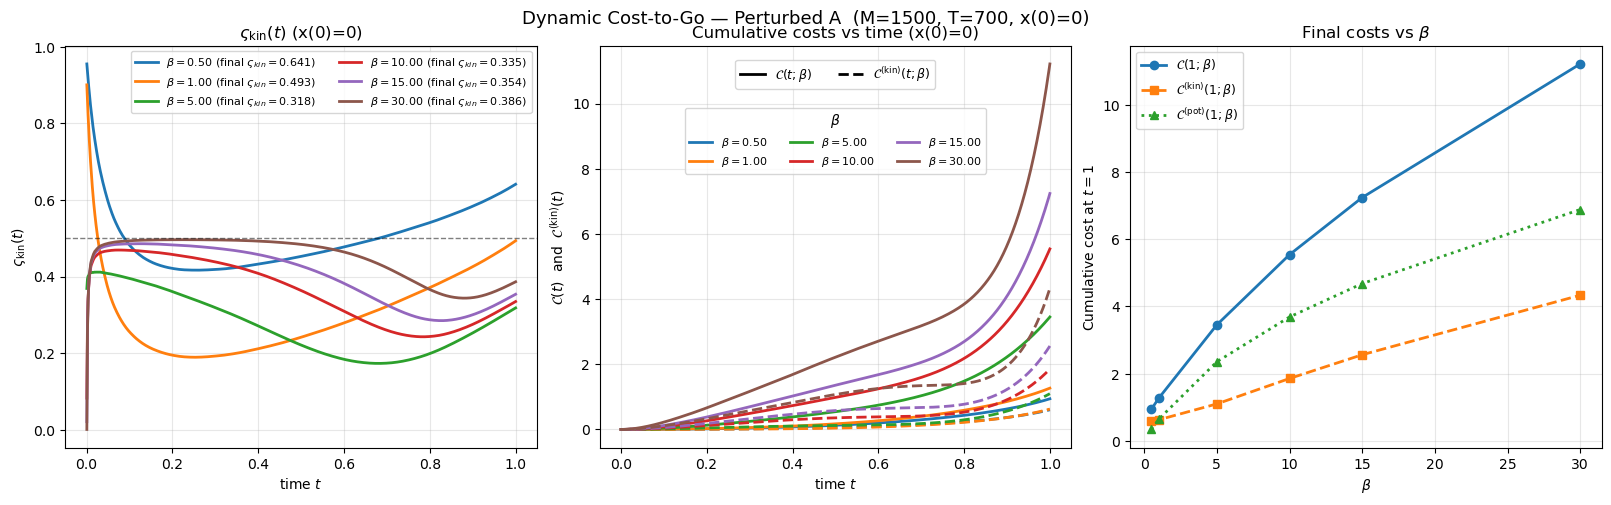

[saved] figs/CostToGo_panels_M1500_T700_perturbed_a.png


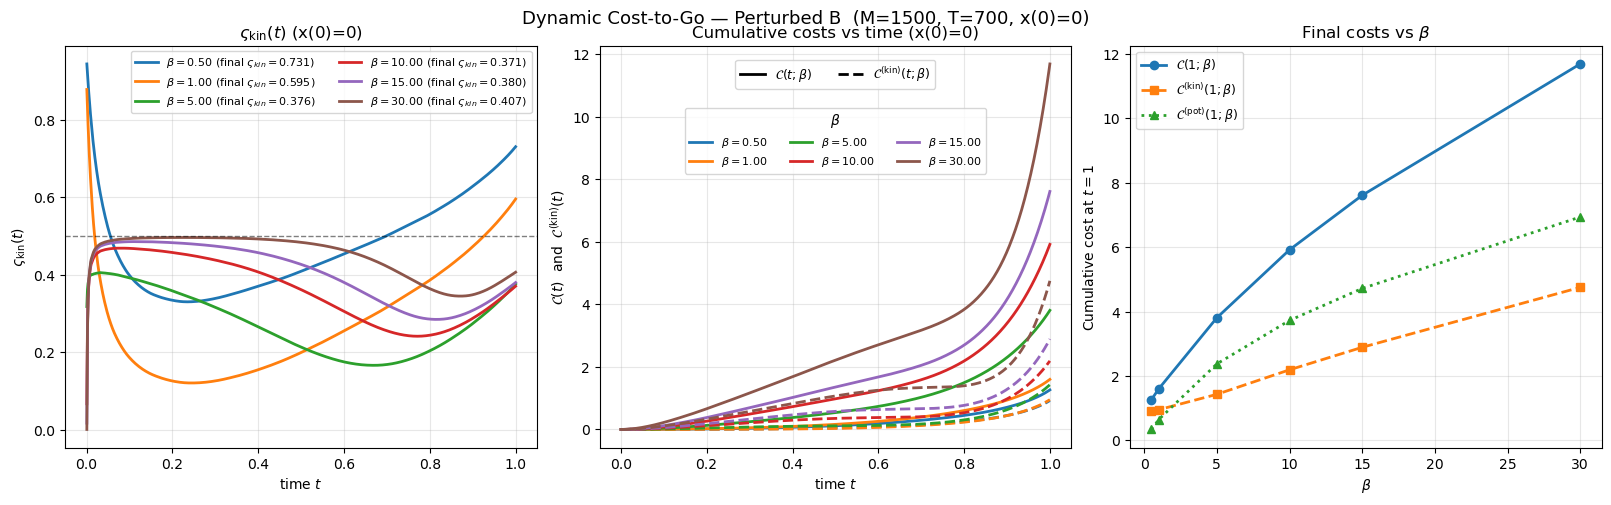

[saved] figs/CostToGo_panels_M1500_T700_perturbed_b.png


In [4]:
import sys
from ada_api_clean import *

# =======================================================
# Dynamic Cost-to-Go — varsigmas vs time [x(0)=0)
#   • Midpoint grid t_n = (n+0.5)/T (never t=0 or t=1)
#   • Potential integrand: (1/2)·β(t)·E[||x_t||²]
#   • SDE: dX = u*(X,t) dt + dW (unit diffusion)
#   • Returns (when return_series=True):
#       t_mid          : (T,)
#       z_kin, z_pot   : (T,) running fractions
#       Ckin_T, Cpot_T : scalars (final integrals)
#       Ckin_series, Cpot_series : (T,) cumulative costs
# =======================================================

import numpy as np, math, os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

os.makedirs("figs", exist_ok=True)

# ---- read β(t) from schedule (PWC or constant) ----
def beta_of_t_from_sched(sched, t: float) -> float:
    if hasattr(sched, "betas") and hasattr(sched, "splits"):  # PWC schedule
        splits = np.asarray(sched.splits, float)
        i = np.searchsorted(splits, float(t), side="right") - 1
        i = max(0, min(i, len(sched.betas) - 1))
        return float(sched.betas[i])
    if hasattr(sched, "beta"):  # constant-β
        return float(sched.beta)
    raise RuntimeError("Schedule must expose either .betas/.splits (PWC) or .beta (constant).")

# ---- endpoint-safe budgets (VERBATIM to notebook logic) ----
def varsigmas_vs_time(sched, gmm, M: int = 2000, T: int = 800, seed: int = 123, x0: str = "zero",
                      return_series: bool = False):
    """
    Simulate with midpoint EM using unit diffusion, accumulate kinetic and potential budgets.
    x0:
      "zero"     -> X(0)=0 for all particles (default)
      "gaussian" -> X(0) ~ N(0, I)
    """
    rng = np.random.default_rng(seed)
    dt    = 1.0 / T
    t_mid = (np.arange(T) + 0.5) / T  # strictly inside (0,1)

    d = gmm.d
    if x0 == "zero":
        X = np.zeros((M, d), float)
    else:
        X = rng.normal(size=(M, d))

    Ckin_T = 0.0
    Cpot_T = 0.0
    z_kin  = np.empty(T, float)
    z_pot  = np.empty(T, float)
    if return_series:
        Ckin_series = np.empty(T, float)
        Cpot_series = np.empty(T, float)

    for n, t in enumerate(t_mid):
        # optimal control u* = b^- ŷ − a^- X
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X

        # advance state
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u * dt + dW

        # accumulate budgets
        Ckin_T += 0.5 * float(np.mean(np.sum(u*u, axis=1))) * dt
        beta_t  = beta_of_t_from_sched(sched, float(t))
        Cpot_T += 0.5 * beta_t * float(np.mean(np.sum(X*X, axis=1))) * dt

        if return_series:
            Ckin_series[n] = Ckin_T
            Cpot_series[n] = Cpot_T

        denom = max(Ckin_T + Cpot_T, 1e-30)
        z_kin[n] = Ckin_T / denom
        z_pot[n] = 1.0 - z_kin[n]

    if return_series:
        return t_mid, z_kin, z_pot, Ckin_T, Cpot_T, Ckin_series, Cpot_series
    else:
        return t_mid, z_kin, z_pot, Ckin_T, Cpot_T

# ------------------ experiment settings (same as your notebook) ------------------
beta_list = [0.5, 1.0, 5.0, 10.0, 15.0, 30.0]
M   = 1500
T   = 700
seed = 42
x0_mode = "zero"   # keep your x(0)=0 convention

models = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]

# ====================== build 3 figures: one per model, 3 panels each ======================
for model_name, gmm in models:
    # Prepare figure with 3 panels (left: z_kin(t); center: cumulative costs; right: final vs β)
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), constrained_layout=True, sharex=False)
    ax_left, ax_center, ax_right = axes

    cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # ---------- LEFT: varsigma_kin(t) ----------
    beta_handles, beta_labels = [], []
    for i, b in enumerate(beta_list):
        color_i = cycle_colors[i % len(cycle_colors)]
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)  # same "touch" as your code
        t, zkin, zpot, Ck, Cp = varsigmas_vs_time(sched, gmm, M=M, T=T, seed=seed, x0=x0_mode)
        ax_left.plot(t, zkin, lw=2.0, color=color_i,
                     label=fr"$\beta={b:.2f}$ (final $\varsigma_{{kin}}={zkin[-1]:.3f}$)")
        beta_handles.append(Line2D([0],[0], color=color_i, lw=2.0))
        beta_labels.append(fr"$\beta={b:.2f}$")
    ax_left.axhline(0.5, ls="--", lw=1.0, color="k", alpha=0.5)
    ax_left.set_xlabel("time $t$")
    ax_left.set_ylabel(r"$\varsigma_{\mathrm{kin}}(t)$")
    ax_left.set_title(r"$\varsigma_{\mathrm{kin}}(t)$ (x(0)=0)")
    ax_left.grid(True, alpha=0.3)
    ax_left.legend(ncol=2, fontsize=8)

    # ---------- CENTER: cumulative costs vs time (C and C_kin) ----------
    style_handles = [
        Line2D([0],[0], color="k", lw=2.0, ls="-"),
        Line2D([0],[0], color="k", lw=2.0, ls="--"),
    ]
    style_labels = [r"$\mathcal{C}(t;\beta)$", r"$\mathcal{C}^{(\mathrm{kin})}(t;\beta)$"]

    beta_handles2, beta_labels2 = [], []
    for i, b in enumerate(beta_list):
        color_i = cycle_colors[i % len(cycle_colors)]
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)
        t, _, _, Ckin_T, Cpot_T, Ckin_series, Cpot_series = varsigmas_vs_time(
            sched, gmm, M=M, T=T, seed=seed, x0=x0_mode, return_series=True
        )
        Ctot_series = Ckin_series + Cpot_series
        ax_center.plot(t, Ctot_series, lw=2.0, color=color_i)
        ax_center.plot(t, Ckin_series, lw=2.0, ls="--", color=color_i)
        beta_handles2.append(Line2D([0],[0], color=color_i, lw=2.0))
        beta_labels2.append(fr"$\beta={b:.2f}$")

    ax_center.set_xlabel("time $t$")
    ax_center.set_ylabel(r"$\mathcal{C}(t)$  and  $\mathcal{C}^{(\mathrm{kin})}(t)$")
    ax_center.set_title(r"Cumulative costs vs time (x(0)=0)")
    ax_center.grid(True, alpha=0.3)

    # top-center stacked legends
    leg_styles = ax_center.legend(style_handles, style_labels,
                                  loc="upper center", bbox_to_anchor=(0.5, 0.98),
                                  ncol=2, frameon=True, fontsize=9)
    ax_center.add_artist(leg_styles)
    ax_center.legend(beta_handles2, beta_labels2,
                     loc="upper center", bbox_to_anchor=(0.5, 0.86),
                     ncol=min(3, len(beta_labels2)), frameon=True, fontsize=8, title=r"$\beta$")

    # ---------- RIGHT: final costs vs β ----------
    Ctot_final, Ckin_final, Cpot_final, zkin_final = [], [], [], []
    for b in beta_list:
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)
        _, _, _, Ckin_T, Cpot_T = varsigmas_vs_time(sched, gmm, M=M, T=T, seed=seed, x0=x0_mode)
        Ctot_final.append(Ckin_T + Cpot_T)
        Ckin_final.append(Ckin_T)
        Cpot_final.append(Cpot_T)
        denom = max(Ckin_T + Cpot_T, 1e-30)
        zkin_final.append(Ckin_T / denom)

    ax_right.plot(beta_list, Ctot_final, marker="o", lw=2.0, label=r"$\mathcal{C}(1;\beta)$")
    ax_right.plot(beta_list, Ckin_final, marker="s", lw=2.0, ls="--", label=r"$\mathcal{C}^{(\mathrm{kin})}(1;\beta)$")
    ax_right.plot(beta_list, Cpot_final, marker="^", lw=2.0, ls=":", label=r"$\mathcal{C}^{(\mathrm{pot})}(1;\beta)$")
    ax_right.set_xlabel(r"$\beta$")
    ax_right.set_ylabel(r"Cumulative cost at $t=1$")
    ax_right.set_title(r"Final costs vs $\beta$")
    ax_right.grid(True, alpha=0.3)
    ax_right.legend(fontsize=9)

    # ---------- title & save ----------
    fig.suptitle(f"Dynamic Cost-to-Go — {model_name}  (M={M}, T={T}, x(0)=0)", y=1.02, fontsize=13)
    fname = f"figs/CostToGo_panels_M{M}_T{T}_" + model_name.lower().replace('×','x').replace(' ','_') + ".png"
    fig.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()
    print("[saved]", fname)


# The same as above, but now with smaller $\beta$ 

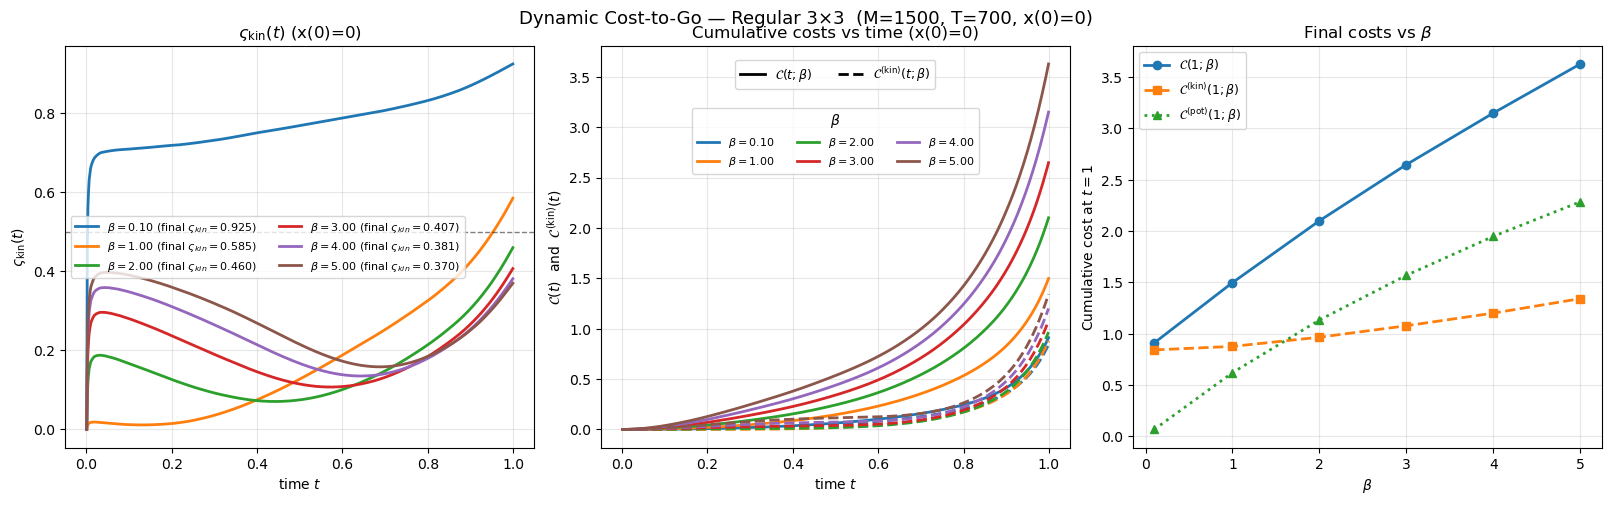

[saved] figs/CostToGo_smaller-beta_panels_M1500_T700_regular_3x3.png


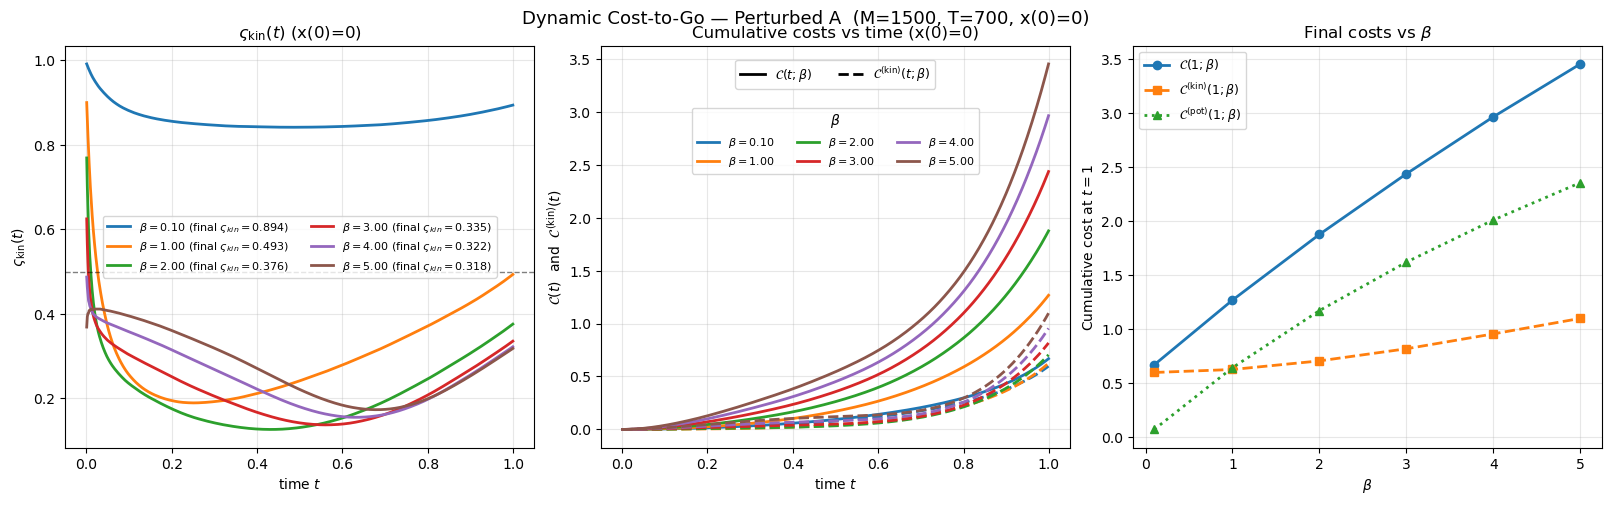

[saved] figs/CostToGo_smaller-beta_panels_M1500_T700_perturbed_a.png


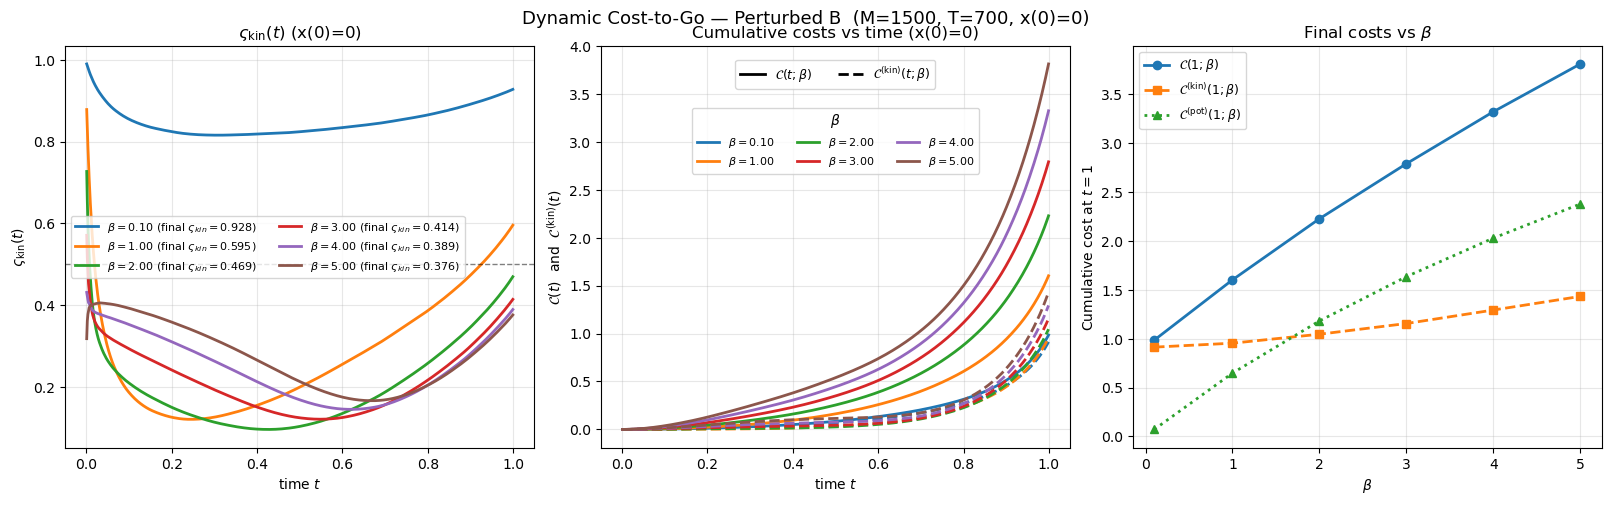

[saved] figs/CostToGo_smaller-beta_panels_M1500_T700_perturbed_b.png


In [5]:
import sys
from ada_api_clean import *

# =======================================================
# Dynamic Cost-to-Go — varsigmas vs time [x(0)=0)
#   • Midpoint grid t_n = (n+0.5)/T (never t=0 or t=1)
#   • Potential integrand: (1/2)·β(t)·E[||x_t||²]
#   • SDE: dX = u*(X,t) dt + dW (unit diffusion)
#   • Returns (when return_series=True):
#       t_mid          : (T,)
#       z_kin, z_pot   : (T,) running fractions
#       Ckin_T, Cpot_T : scalars (final integrals)
#       Ckin_series, Cpot_series : (T,) cumulative costs
# =======================================================

import numpy as np, math, os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

os.makedirs("figs", exist_ok=True)

# ---- read β(t) from schedule (PWC or constant) ----
def beta_of_t_from_sched(sched, t: float) -> float:
    if hasattr(sched, "betas") and hasattr(sched, "splits"):  # PWC schedule
        splits = np.asarray(sched.splits, float)
        i = np.searchsorted(splits, float(t), side="right") - 1
        i = max(0, min(i, len(sched.betas) - 1))
        return float(sched.betas[i])
    if hasattr(sched, "beta"):  # constant-β
        return float(sched.beta)
    raise RuntimeError("Schedule must expose either .betas/.splits (PWC) or .beta (constant).")

# ---- endpoint-safe budgets (VERBATIM to notebook logic) ----
def varsigmas_vs_time(sched, gmm, M: int = 2000, T: int = 800, seed: int = 123, x0: str = "zero",
                      return_series: bool = False):
    """
    Simulate with midpoint EM using unit diffusion, accumulate kinetic and potential budgets.
    x0:
      "zero"     -> X(0)=0 for all particles (default)
      "gaussian" -> X(0) ~ N(0, I)
    """
    rng = np.random.default_rng(seed)
    dt    = 1.0 / T
    t_mid = (np.arange(T) + 0.5) / T  # strictly inside (0,1)

    d = gmm.d
    if x0 == "zero":
        X = np.zeros((M, d), float)
    else:
        X = rng.normal(size=(M, d))

    Ckin_T = 0.0
    Cpot_T = 0.0
    z_kin  = np.empty(T, float)
    z_pot  = np.empty(T, float)
    if return_series:
        Ckin_series = np.empty(T, float)
        Cpot_series = np.empty(T, float)

    for n, t in enumerate(t_mid):
        # optimal control u* = b^- ŷ − a^- X
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X

        # advance state
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u * dt + dW

        # accumulate budgets
        Ckin_T += 0.5 * float(np.mean(np.sum(u*u, axis=1))) * dt
        beta_t  = beta_of_t_from_sched(sched, float(t))
        Cpot_T += 0.5 * beta_t * float(np.mean(np.sum(X*X, axis=1))) * dt

        if return_series:
            Ckin_series[n] = Ckin_T
            Cpot_series[n] = Cpot_T

        denom = max(Ckin_T + Cpot_T, 1e-30)
        z_kin[n] = Ckin_T / denom
        z_pot[n] = 1.0 - z_kin[n]

    if return_series:
        return t_mid, z_kin, z_pot, Ckin_T, Cpot_T, Ckin_series, Cpot_series
    else:
        return t_mid, z_kin, z_pot, Ckin_T, Cpot_T

# ------------------ experiment settings (same as your notebook) ------------------
beta_list = [0.1, 1.0, 2.0, 3.0, 4.0, 5.0]
M   = 1500
T   = 700
seed = 42
x0_mode = "zero"   # keep your x(0)=0 convention

models = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]

# ====================== build 3 figures: one per model, 3 panels each ======================
for model_name, gmm in models:
    # Prepare figure with 3 panels (left: z_kin(t); center: cumulative costs; right: final vs β)
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), constrained_layout=True, sharex=False)
    ax_left, ax_center, ax_right = axes

    cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # ---------- LEFT: varsigma_kin(t) ----------
    beta_handles, beta_labels = [], []
    for i, b in enumerate(beta_list):
        color_i = cycle_colors[i % len(cycle_colors)]
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)  # same "touch" as your code
        t, zkin, zpot, Ck, Cp = varsigmas_vs_time(sched, gmm, M=M, T=T, seed=seed, x0=x0_mode)
        ax_left.plot(t, zkin, lw=2.0, color=color_i,
                     label=fr"$\beta={b:.2f}$ (final $\varsigma_{{kin}}={zkin[-1]:.3f}$)")
        beta_handles.append(Line2D([0],[0], color=color_i, lw=2.0))
        beta_labels.append(fr"$\beta={b:.2f}$")
    ax_left.axhline(0.5, ls="--", lw=1.0, color="k", alpha=0.5)
    ax_left.set_xlabel("time $t$")
    ax_left.set_ylabel(r"$\varsigma_{\mathrm{kin}}(t)$")
    ax_left.set_title(r"$\varsigma_{\mathrm{kin}}(t)$ (x(0)=0)")
    ax_left.grid(True, alpha=0.3)
    ax_left.legend(ncol=2, fontsize=8)

    # ---------- CENTER: cumulative costs vs time (C and C_kin) ----------
    style_handles = [
        Line2D([0],[0], color="k", lw=2.0, ls="-"),
        Line2D([0],[0], color="k", lw=2.0, ls="--"),
    ]
    style_labels = [r"$\mathcal{C}(t;\beta)$", r"$\mathcal{C}^{(\mathrm{kin})}(t;\beta)$"]

    beta_handles2, beta_labels2 = [], []
    for i, b in enumerate(beta_list):
        color_i = cycle_colors[i % len(cycle_colors)]
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)
        t, _, _, Ckin_T, Cpot_T, Ckin_series, Cpot_series = varsigmas_vs_time(
            sched, gmm, M=M, T=T, seed=seed, x0=x0_mode, return_series=True
        )
        Ctot_series = Ckin_series + Cpot_series
        ax_center.plot(t, Ctot_series, lw=2.0, color=color_i)
        ax_center.plot(t, Ckin_series, lw=2.0, ls="--", color=color_i)
        beta_handles2.append(Line2D([0],[0], color=color_i, lw=2.0))
        beta_labels2.append(fr"$\beta={b:.2f}$")

    ax_center.set_xlabel("time $t$")
    ax_center.set_ylabel(r"$\mathcal{C}(t)$  and  $\mathcal{C}^{(\mathrm{kin})}(t)$")
    ax_center.set_title(r"Cumulative costs vs time (x(0)=0)")
    ax_center.grid(True, alpha=0.3)

    # top-center stacked legends
    leg_styles = ax_center.legend(style_handles, style_labels,
                                  loc="upper center", bbox_to_anchor=(0.5, 0.98),
                                  ncol=2, frameon=True, fontsize=9)
    ax_center.add_artist(leg_styles)
    ax_center.legend(beta_handles2, beta_labels2,
                     loc="upper center", bbox_to_anchor=(0.5, 0.86),
                     ncol=min(3, len(beta_labels2)), frameon=True, fontsize=8, title=r"$\beta$")

    # ---------- RIGHT: final costs vs β ----------
    Ctot_final, Ckin_final, Cpot_final, zkin_final = [], [], [], []
    for b in beta_list:
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)
        _, _, _, Ckin_T, Cpot_T = varsigmas_vs_time(sched, gmm, M=M, T=T, seed=seed, x0=x0_mode)
        Ctot_final.append(Ckin_T + Cpot_T)
        Ckin_final.append(Ckin_T)
        Cpot_final.append(Cpot_T)
        denom = max(Ckin_T + Cpot_T, 1e-30)
        zkin_final.append(Ckin_T / denom)

    ax_right.plot(beta_list, Ctot_final, marker="o", lw=2.0, label=r"$\mathcal{C}(1;\beta)$")
    ax_right.plot(beta_list, Ckin_final, marker="s", lw=2.0, ls="--", label=r"$\mathcal{C}^{(\mathrm{kin})}(1;\beta)$")
    ax_right.plot(beta_list, Cpot_final, marker="^", lw=2.0, ls=":", label=r"$\mathcal{C}^{(\mathrm{pot})}(1;\beta)$")
    ax_right.set_xlabel(r"$\beta$")
    ax_right.set_ylabel(r"Cumulative cost at $t=1$")
    ax_right.set_title(r"Final costs vs $\beta$")
    ax_right.grid(True, alpha=0.3)
    ax_right.legend(fontsize=9)

    # ---------- title & save ----------
    fig.suptitle(f"Dynamic Cost-to-Go — {model_name}  (M={M}, T={T}, x(0)=0)", y=1.02, fontsize=13)
    fname = f"figs/CostToGo_smaller-beta_panels_M{M}_T{T}_" + model_name.lower().replace('×','x').replace(' ','_') + ".png"
    fig.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()
    print("[saved]", fname)
